<a href="https://colab.research.google.com/github/ManarCSAlharbi/cpcs433/blob/main/CPCS433_Project_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking Space Occupancy Classification Using Machine Learning (SVM) and Deep Learning (CNN) - CPCS433 Project
---
**Team members:**
* Shatha Alshaikh 2206240
* Manar Alharbi  22067122
* Rasha Alsabouni 21295093
* Gala Omar Aldossary 2210656  
* Sarah Algarni 2205539


## 1. Import Libraries

In [ ]:
import os
import kagglehub
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

#for feature extraction part
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import Pipeline
from joblib import dump, load
from tqdm import tqdm


##  2. Load Dataset


In [ ]:

path = kagglehub.dataset_download("ammarnassanalhajali/pklot-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pklot-dataset' dataset.
Path to dataset files: /kaggle/input/pklot-dataset


In [ ]:
print(f"Contents of the root dataset directory ({path}):")
for item in os.listdir(path):
    print(f"- {item}")


Contents of the root dataset directory (/kaggle/input/pklot-dataset):
- README.dataset.txt
- README.roboflow.txt
- valid
- test
- train


##  3. Preprocessing & Train/Validation Split




In [ ]:
import os
import cv2
import json

# Root directory of the dataset
root = "/kaggle/input/pklot-dataset"

# Output directory
output_dir = "/kaggle/working/pklot_classification"
os.makedirs(f"{output_dir}/Empty", exist_ok=True)
os.makedirs(f"{output_dir}/Occupied", exist_ok=True)


split = "valid"

# Class mapping
class_map = {
    1: "Empty",
    2: "Occupied"
}

# Balance target
target_per_class = 20000  # 40k Empty + 40k Occupied = 80k total

# Counters
empty_count = 0
occupied_count = 0

# Load COCO file
json_path = f"{root}/{split}/_annotations.coco.json"
images_dir = f"{root}/{split}"

with open(json_path, "r") as f:
    data = json.load(f)

# Dictionary image_id → file info
images = {img["id"]: img for img in data["images"]}

# Loop over annotations
for ann in data["annotations"]:

    # Skip category 0
    if ann["category_id"] == 0:
        continue

    cls = class_map[ann["category_id"]]

    # Check balance condition
    if cls == "Empty" and empty_count >= target_per_class:
        continue
    if cls == "Occupied" and occupied_count >= target_per_class:
        continue

    img_info = images[ann["image_id"]]
    file_name = img_info["file_name"]
    img_path = os.path.join(images_dir, file_name)

    img = cv2.imread(img_path)
    if img is None:
        continue

    # Extract bounding box
    x, y, w, h = map(int, ann["bbox"])
    roi = img[y:y+h, x:x+w]

    if roi.size == 0:
        continue

    # Save ROI
    save_path = f"{output_dir}/{cls}/{file_name.replace('.jpg','').replace('.png','')}_{ann['id']}.jpg"
    cv2.imwrite(save_path, roi)

    # Update counters
    if cls == "Empty":
        empty_count += 1
    else:
        occupied_count += 1

    # Stop when balanced goal is reached
    if empty_count >= target_per_class and occupied_count >= target_per_class:
        break

print("Finished!")

Finished!


In [ ]:
empty_count = len(os.listdir(os.path.join(output_dir, "Empty")))
occupied_count = len(os.listdir(os.path.join(output_dir, "Occupied")))

total = empty_count + occupied_count

print("Number of Empty images:", empty_count)
print("Number of Occupied images:", occupied_count)
print("Total images:", total)

Number of Empty images: 20000
Number of Occupied images: 20000
Total images: 40000


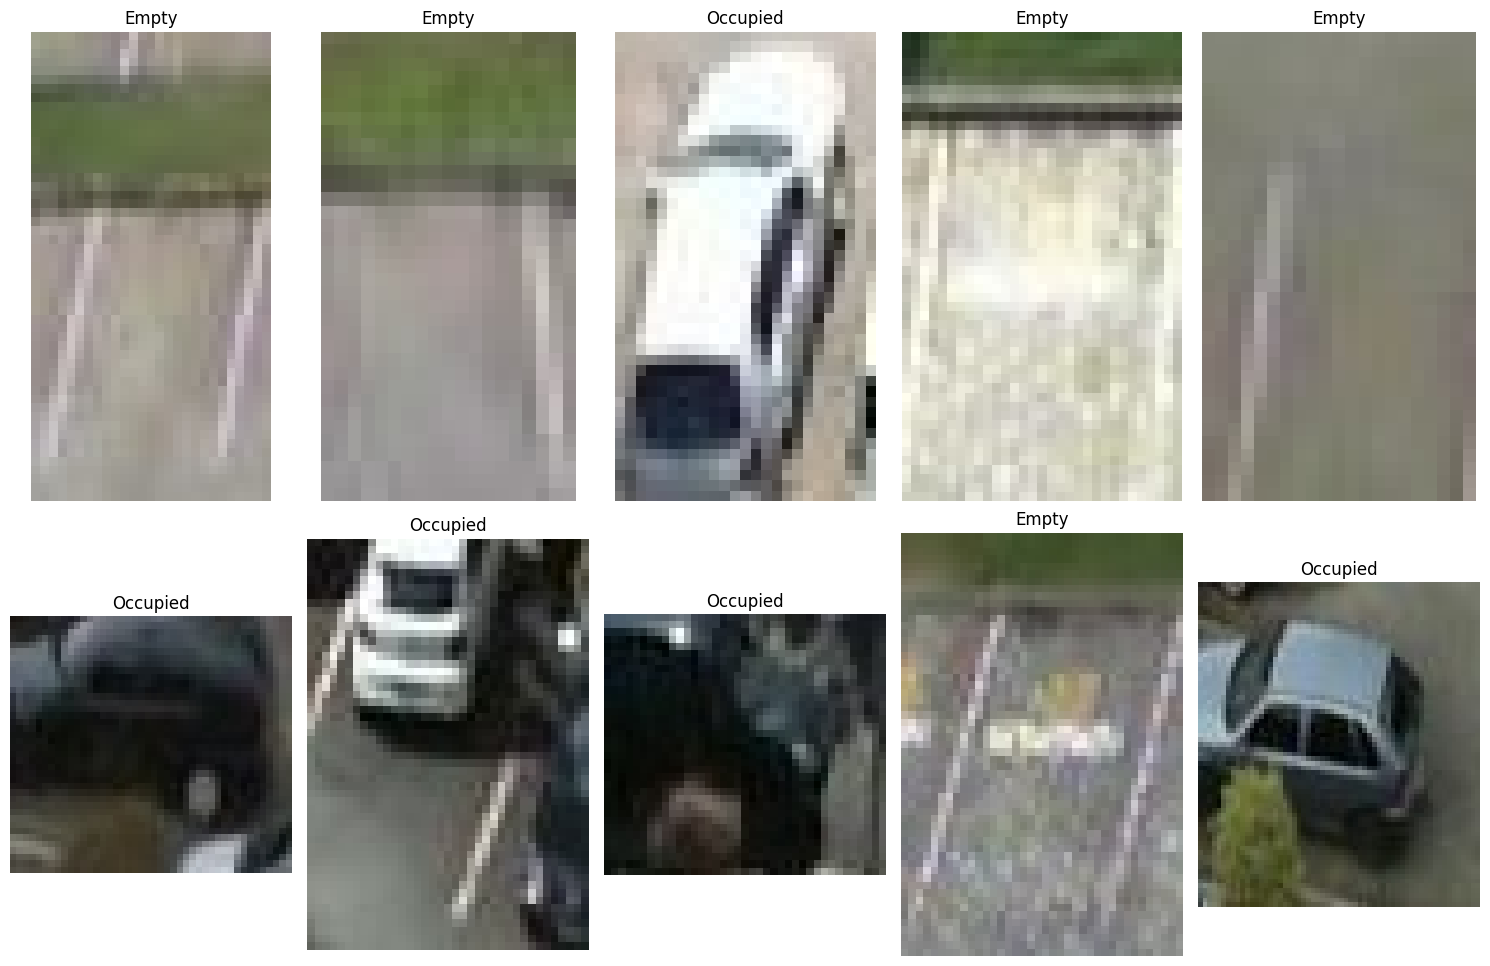

In [ ]:
# Collect all images with their labels
all_images = []
for label in ["Empty", "Occupied"]:
    class_folder = os.path.join(output_dir, label)
    for img_name in os.listdir(class_folder):
        all_images.append((os.path.join(class_folder, img_name), label))

# Randomly pick 10 images
sample_images = random.sample(all_images, 10)

# Plot the images
plt.figure(figsize=(15, 10))

for i, (img_path, label) in enumerate(sample_images, 1):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
dataset_path = "/kaggle/working/pklot_classification"

# Lists to store images and labels
X = []
y = []

In [ ]:
# Resize function
def resize_image(img):
    return cv2.resize(img, (64, 64))

# Convert BGR to grayscale
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Convert images to arrays & load dataset

In [ ]:
# Loop through class folders (Empty, Occupied)
for label_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label_name)

    if not os.path.isdir(class_dir):
        continue

    # Loop through each image inside the class folder
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        # Load the image
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Resize
        img = resize_image(img)

        # Grayscale
        img = to_gray(img)

        # Normalize to [0,1]
        img = img / 255.0

        # Append to arrays
        X.append(img)
        y.append(label_name)

print("Images loaded and processed successfully!")

Images loaded and processed successfully!


Convert list to NumPy arrays

In [ ]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (40000, 64, 64)
y shape: (40000,)


Label Encoding

In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Classes encoded:", encoder.classes_)

Classes encoded: ['Empty' 'Occupied']


Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, shuffle=True
)

print("Train/Test split complete!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Train/Test split complete!
X_train shape: (32000, 64, 64)
X_test shape: (8000, 64, 64)


In [ ]:
# CNN reshape
X_train_cnn = X_train.reshape(-1, 64, 64, 1)
X_test_cnn  = X_test.reshape(-1, 64, 64, 1)

print("CNN train shape:", X_train_cnn.shape)
print("CNN test shape:", X_test_cnn.shape)

CNN train shape: (32000, 64, 64, 1)
CNN test shape: (8000, 64, 64, 1)


In [ ]:
# SVM reshape (flatten)
X_train_svm = X_train.reshape(-1, 64 * 64)
X_test_svm  = X_test.reshape(-1, 64 * 64)

print("SVM train shape:", X_train_svm.shape)
print("SVM test shape:", X_test_svm.shape)

SVM train shape: (32000, 4096)
SVM test shape: (8000, 4096)


## 4. Feature Extraction for SVM (HOG & ORB & LBP)

**1. HOG Feature extraction method**

Define arrays for store the features and labels

In [ ]:
X_train_features = []
X_test_features  = []

y_train_svm_labels = y_train
y_test_svm_labels  = y_test


Extract HOG Features

In [ ]:
#train
for img in X_train_svm:
    img_2d = img.reshape(64, 64)  #Convert the img to 2d
    features = hog(img_2d,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys')
    X_train_features.append(features)

# test
for img in X_test_svm:
    img_2d = img.reshape(64, 64)
    features = hog(img_2d,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys')
    X_test_features.append(features)


Convert the lists to Numpy arrays

In [ ]:
X_train_features = np.array(X_train_features)
X_test_features  = np.array(X_test_features)

print("Train features shape:", X_train_features.shape)
print("Test features shape:", X_test_features.shape)


Train features shape: (32000, 1764)
Test features shape: (8000, 1764)


Scaling for SVM

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled  = scaler.transform(X_test_features)


Saved to used later

In [ ]:
np.save('X_train_features_scaled.npy', X_train_scaled)
np.save('X_test_features_scaled.npy', X_test_scaled)
np.save('y_train_svm_labels.npy', y_train_svm_labels)
np.save('y_test_svm_labels.npy', y_test_svm_labels)


Visulaize the result

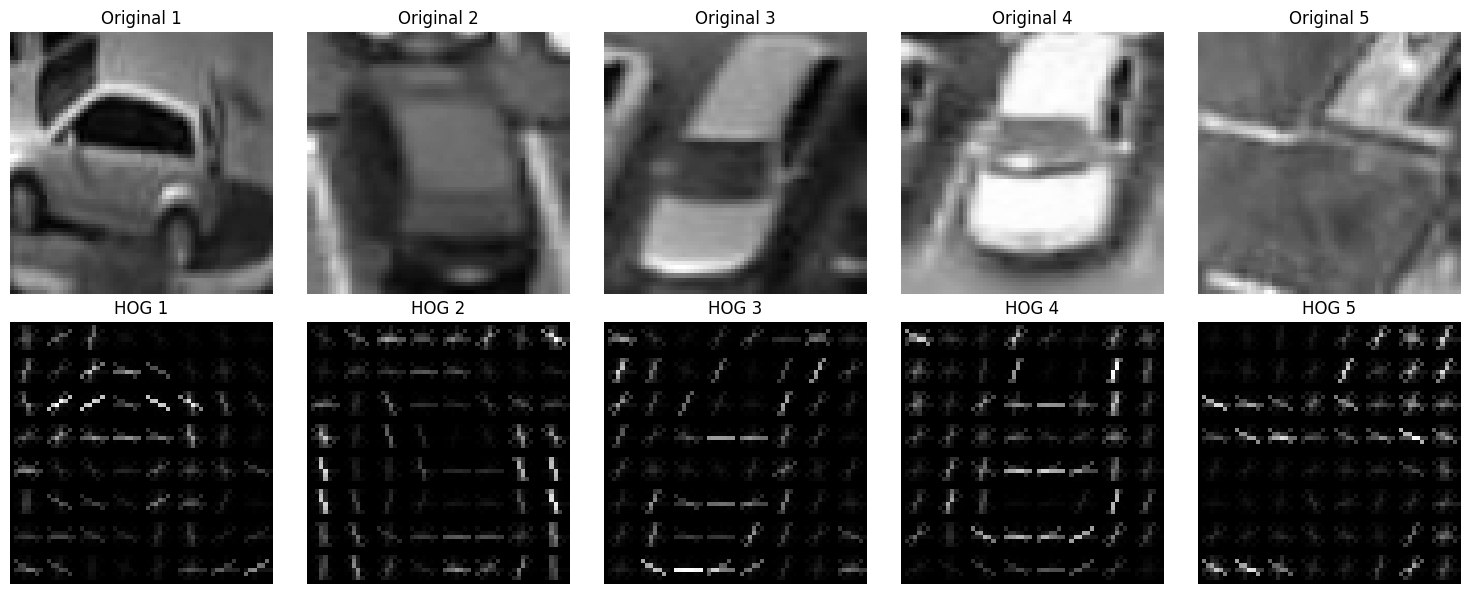

In [ ]:
from skimage.feature import hog
import matplotlib.pyplot as plt

num_examples = 5

plt.figure(figsize=(15,6))

for i in range(num_examples):
    img_2d = X_train_svm[i].reshape(64,64)

    # Extract HOG with visualization
    features, hog_image = hog(img_2d,
                              orientations=9,
                              pixels_per_cell=(8,8),
                              cells_per_block=(2,2),
                              block_norm='L2-Hys',
                              visualize=True)

    plt.subplot(2, num_examples, i+1)
    plt.imshow(img_2d, cmap='gray')
    plt.title(f"Original {i+1}")
    plt.axis('off')

    plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"HOG {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()



2.**ORB Feature extraction method**


Extract descreption for each img

In [ ]:
orb = cv2.ORB_create(nfeatures=500)

all_descriptors = []

for img in X_train_svm:
    img_2d = (img * 255).astype(np.uint8).reshape(64,64)
    kp, des = orb.detectAndCompute(img_2d, None)
    if des is not None:
        all_descriptors.append(des)


all_descriptors = np.vstack(all_descriptors)
print("Total descriptors shape:", all_descriptors.shape)


Total descriptors shape: (793, 32)


Culestring for visual vocabulary

In [ ]:
k = 100
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
kmeans.fit(all_descriptors)


MiniBatchKMeans(n_clusters=100, random_state=42)

represent each img as histogram

In [ ]:
def extract_bovw_features(img, orb, kmeans):
    img_2d = (img * 255).astype(np.uint8).reshape(64,64)
    kp, des = orb.detectAndCompute(img_2d, None)
    if des is None:
        return np.zeros(kmeans.n_clusters)
    words = kmeans.predict(des)
    hist, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters+1))
    hist = hist / np.linalg.norm(hist)
    return hist

X_train_orb = np.array([extract_bovw_features(img, orb, kmeans) for img in X_train_svm])
X_test_orb  = np.array([extract_bovw_features(img, orb, kmeans) for img in X_test_svm])

print("ORB BOVW train shape:", X_train_orb.shape)
print("ORB BOVW test shape:", X_test_orb.shape)


ORB BOVW train shape: (32000, 100)
ORB BOVW test shape: (8000, 100)


Visulize the result

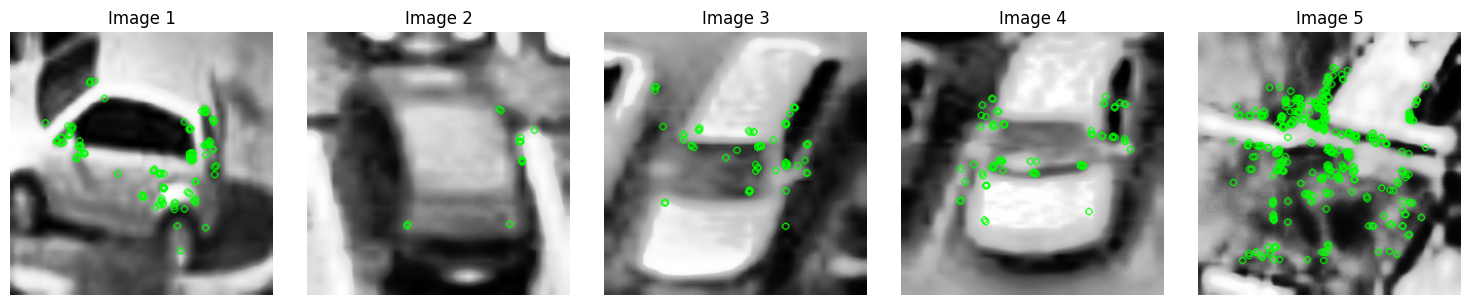

In [ ]:
import cv2
import matplotlib.pyplot as plt

# create ORB detector
orb = cv2.ORB_create(nfeatures=1000)


num_examples = 5

plt.figure(figsize=(15,3))

for i in range(num_examples):
    img_2d = (X_train_svm[i] * 255).astype(np.uint8).reshape(64,64)
    # Scale
    img_large = cv2.resize(img_2d, (256,256))

    # Enhance
    img_large = cv2.equalizeHist(img_large)

    # detect keypoints
    kp, des = orb.detectAndCompute(img_large, None)

    # draw keypoints
    img_kp = cv2.drawKeypoints(img_large, kp, None, color=(0,255,0), flags=0)

    # show imgs
    plt.subplot(1, num_examples, i+1)
    plt.imshow(img_kp, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()



3.**LBP Feature Extraction method**

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare the parameters
radius = 3
n_points = 8 * radius


X_train_lbp = []
X_test_lbp = []

# Train
for img in X_train_svm:
    img_2d = img.reshape(64,64)
    lbp = local_binary_pattern(img_2d, n_points, radius, method='uniform')

    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points+3), density=True)
    X_train_lbp.append(hist)

# Test
for img in X_test_svm:
    img_2d = img.reshape(64,64)
    lbp = local_binary_pattern(img_2d, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points+3), density=True)
    X_test_lbp.append(hist)


X_train_lbp = np.array(X_train_lbp)
X_test_lbp = np.array(X_test_lbp)

print("LBP Train features shape:", X_train_lbp.shape)
print("LBP Test features shape:", X_test_lbp.shape)


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP Train features shape: (32000, 26)
LBP Test features shape: (8000, 26)


LBP Scaling

In [ ]:
scaler_lbp = StandardScaler()
X_train_lbp_scaled = scaler_lbp.fit_transform(X_train_lbp)
X_test_lbp_scaled  = scaler_lbp.transform(X_test_lbp)


Visulize the result

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


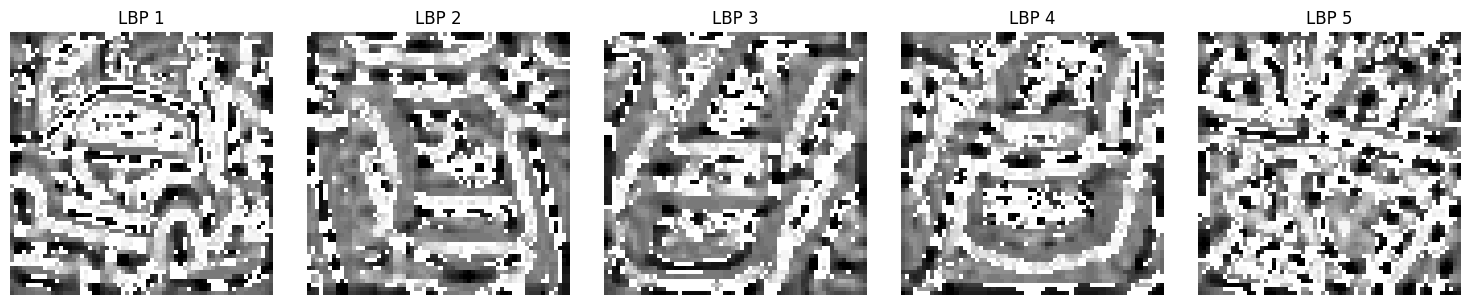

In [ ]:
import matplotlib.pyplot as plt

num_examples = 5

plt.figure(figsize=(15,3))

for i in range(num_examples):
    img_2d = X_train_svm[i].reshape(64,64)
    lbp = local_binary_pattern(img_2d, n_points, radius, method='uniform')

    plt.subplot(1, num_examples, i+1)
    plt.imshow(lbp, cmap='gray')
    plt.title(f"LBP {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


##  5. Train SVM Classifier

We trained separate SVM models for each feature extraction method (HOG, ORB, LBP) using 3-fold cross-validation.

In [ ]:
# Import necessary libraries for SVM training
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

### Train SVM with HOG Features

In [ ]:
# Train SVM with HOG Features
print("=" * 60)
print("Training SVM with HOG Features")
print("=" * 60)

# Load the saved HOG features
X_train_hog = np.load('X_train_features_scaled.npy')
X_test_hog = np.load('X_test_features_scaled.npy')
y_train_hog = np.load('y_train_svm_labels.npy')
y_test_hog = np.load('y_test_svm_labels.npy')

print(f"Training data shape: {X_train_hog.shape}")
print(f"Testing data shape: {X_test_hog.shape}")

# Initialize SVM classifier
svm_hog = SVC(kernel='rbf', random_state=42)

# Perform 3-fold cross-validation
print("\nPerforming 3-Fold Cross-Validation...")
start_time = time.time()
cv_scores_hog = cross_val_score(svm_hog, X_train_hog, y_train_hog, cv=3, scoring='accuracy', verbose=1)
cv_time = time.time() - start_time

print(f"\nCross-Validation Results:")
print(f"Fold 1 Accuracy: {cv_scores_hog[0]:.4f}")
print(f"Fold 2 Accuracy: {cv_scores_hog[1]:.4f}")
print(f"Fold 3 Accuracy: {cv_scores_hog[2]:.4f}")
print(f"Mean CV Accuracy: {cv_scores_hog.mean():.4f} (+/- {cv_scores_hog.std() * 2:.4f})")
print(f"Cross-Validation Time: {cv_time:.2f} seconds")

# Train on full training set
print("\nTraining on full training set...")
start_time = time.time()
svm_hog.fit(X_train_hog, y_train_hog)
train_time = time.time() - start_time
print(f"Training Time: {train_time:.2f} seconds")

# Evaluate on test set
y_pred_hog = svm_hog.predict(X_test_hog)
test_accuracy_hog = accuracy_score(y_test_hog, y_pred_hog)

print(f"\n{'='*60}")
print(f"HOG + SVM Test Accuracy: {test_accuracy_hog:.4f}")
print(f"{'='*60}")

Training SVM with HOG Features
Training data shape: (32000, 1764)
Testing data shape: (8000, 1764)

Performing 3-Fold Cross-Validation...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.7min finished



Cross-Validation Results:
Fold 1 Accuracy: 0.9728
Fold 2 Accuracy: 0.9765
Fold 3 Accuracy: 0.9746
Mean CV Accuracy: 0.9746 (+/- 0.0030)
Cross-Validation Time: 1239.64 seconds

Training on full training set...
Training Time: 699.60 seconds

HOG + SVM Test Accuracy: 0.9730


### Display detailed results for HOG

In [ ]:
# Display detailed results for HOG
print("\nClassification Report (HOG + SVM):")
print(classification_report(y_test_hog, y_pred_hog, target_names=['Empty', 'Occupied']))

print("\nConfusion Matrix (HOG + SVM):")
cm_hog = confusion_matrix(y_test_hog, y_pred_hog)
print(cm_hog)


Classification Report (HOG + SVM):
              precision    recall  f1-score   support

       Empty       1.00      0.95      0.97      3986
    Occupied       0.95      1.00      0.97      4014

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


Confusion Matrix (HOG + SVM):
[[3786  200]
 [  16 3998]]


### Visualize Confusion Matrix for HOG

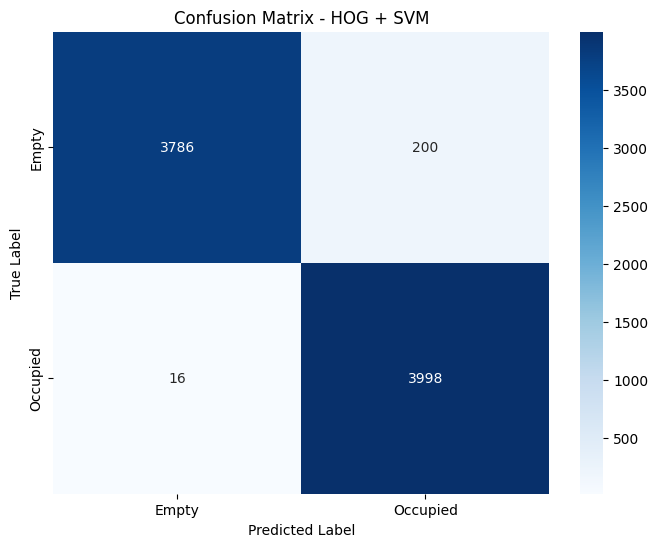

In [ ]:
# Visualize Confusion Matrix for HOG
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm_hog, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Empty', 'Occupied'],
            yticklabels=['Empty', 'Occupied'])
plt.title('Confusion Matrix - HOG + SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Train SVM with ORB Features

In [ ]:
# Train SVM with ORB Features
print("=" * 60)
print("Training SVM with ORB Features")
print("=" * 60)

print(f"Training data shape: {X_train_orb.shape}")
print(f"Testing data shape: {X_test_orb.shape}")

# Initialize SVM classifier
svm_orb = SVC(kernel='rbf', random_state=42)

# Perform 3-fold cross-validation
print("\nPerforming 3-Fold Cross-Validation...")
start_time = time.time()
cv_scores_orb = cross_val_score(svm_orb, X_train_orb, y_train_svm_labels, cv=3, scoring='accuracy', verbose=1)
cv_time = time.time() - start_time

print(f"\nCross-Validation Results:")
print(f"Fold 1 Accuracy: {cv_scores_orb[0]:.4f}")
print(f"Fold 2 Accuracy: {cv_scores_orb[1]:.4f}")
print(f"Fold 3 Accuracy: {cv_scores_orb[2]:.4f}")
print(f"Mean CV Accuracy: {cv_scores_orb.mean():.4f} (+/- {cv_scores_orb.std() * 2:.4f})")
print(f"Cross-Validation Time: {cv_time:.2f} seconds")

# Train on full training set
print("\nTraining on full training set...")
start_time = time.time()
svm_orb.fit(X_train_orb, y_train_svm_labels)
train_time = time.time() - start_time
print(f"Training Time: {train_time:.2f} seconds")

# Evaluate on test set
y_pred_orb = svm_orb.predict(X_test_orb)
test_accuracy_orb = accuracy_score(y_test_svm_labels, y_pred_orb)

print(f"\n{'='*60}")
print(f"ORB + SVM Test Accuracy: {test_accuracy_orb:.4f}")
print(f"{'='*60}")

Training SVM with ORB Features
Training data shape: (32000, 100)
Testing data shape: (8000, 100)

Performing 3-Fold Cross-Validation...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min finished



Cross-Validation Results:
Fold 1 Accuracy: 0.5181
Fold 2 Accuracy: 0.5142
Fold 3 Accuracy: 0.5141
Mean CV Accuracy: 0.5155 (+/- 0.0038)
Cross-Validation Time: 150.73 seconds

Training on full training set...
Training Time: 57.10 seconds

ORB + SVM Test Accuracy: 0.5149


### Display detailed results for ORB

In [ ]:
# Display detailed results for ORB
print("\nClassification Report (ORB + SVM):")
print(classification_report(y_test_svm_labels, y_pred_orb, target_names=['Empty', 'Occupied']))

print("\nConfusion Matrix (ORB + SVM):")
cm_orb = confusion_matrix(y_test_svm_labels, y_pred_orb)
print(cm_orb)


Classification Report (ORB + SVM):
              precision    recall  f1-score   support

       Empty       0.51      0.99      0.67      3986
    Occupied       0.88      0.04      0.07      4014

    accuracy                           0.51      8000
   macro avg       0.69      0.52      0.37      8000
weighted avg       0.69      0.51      0.37      8000


Confusion Matrix (ORB + SVM):
[[3965   21]
 [3860  154]]


### Visualize Confusion Matrix for ORB

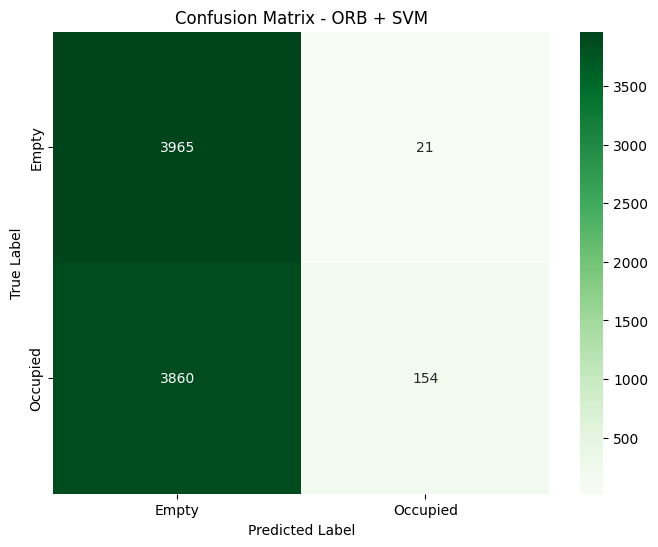

In [ ]:
# Visualize Confusion Matrix for ORB
plt.figure(figsize=(8, 6))
sns.heatmap(cm_orb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Empty', 'Occupied'],
            yticklabels=['Empty', 'Occupied'])
plt.title('Confusion Matrix - ORB + SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Train SVM with LBP Features

In [ ]:
# Train SVM with LBP Features
print("=" * 60)
print("Training SVM with LBP Features")
print("=" * 60)

print(f"Training data shape: {X_train_lbp_scaled.shape}")
print(f"Testing data shape: {X_test_lbp_scaled.shape}")

# Initialize SVM classifier
svm_lbp = SVC(kernel='rbf', random_state=42)

# Perform 3-fold cross-validation
print("\nPerforming 3-Fold Cross-Validation...")
start_time = time.time()
cv_scores_lbp = cross_val_score(svm_lbp, X_train_lbp_scaled, y_train_svm_labels, cv=3, scoring='accuracy', verbose=1)
cv_time = time.time() - start_time

print(f"\nCross-Validation Results:")
print(f"Fold 1 Accuracy: {cv_scores_lbp[0]:.4f}")
print(f"Fold 2 Accuracy: {cv_scores_lbp[1]:.4f}")
print(f"Fold 3 Accuracy: {cv_scores_lbp[2]:.4f}")
print(f"Mean CV Accuracy: {cv_scores_lbp.mean():.4f} (+/- {cv_scores_lbp.std() * 2:.4f})")
print(f"Cross-Validation Time: {cv_time:.2f} seconds")

# Train on full training set
print("\nTraining on full training set...")
start_time = time.time()
svm_lbp.fit(X_train_lbp_scaled, y_train_svm_labels)
train_time = time.time() - start_time
print(f"Training Time: {train_time:.2f} seconds")

# Evaluate on test set
y_pred_lbp = svm_lbp.predict(X_test_lbp_scaled)
test_accuracy_lbp = accuracy_score(y_test_svm_labels, y_pred_lbp)

print(f"\n{'='*60}")
print(f"LBP + SVM Test Accuracy: {test_accuracy_lbp:.4f}")
print(f"{'='*60}")

Training SVM with LBP Features
Training data shape: (32000, 26)
Testing data shape: (8000, 26)

Performing 3-Fold Cross-Validation...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.9s finished



Cross-Validation Results:
Fold 1 Accuracy: 0.8671
Fold 2 Accuracy: 0.8636
Fold 3 Accuracy: 0.8661
Mean CV Accuracy: 0.8656 (+/- 0.0029)
Cross-Validation Time: 46.89 seconds

Training on full training set...
Training Time: 22.24 seconds

LBP + SVM Test Accuracy: 0.8662


### Display detailed results for LBP

In [ ]:
# Display detailed results for LBP
print("\nClassification Report (LBP + SVM):")
print(classification_report(y_test_svm_labels, y_pred_lbp, target_names=['Empty', 'Occupied']))

print("\nConfusion Matrix (LBP + SVM):")
cm_lbp = confusion_matrix(y_test_svm_labels, y_pred_lbp)
print(cm_lbp)


Classification Report (LBP + SVM):
              precision    recall  f1-score   support

       Empty       0.89      0.83      0.86      3986
    Occupied       0.84      0.90      0.87      4014

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000


Confusion Matrix (LBP + SVM):
[[3311  675]
 [ 395 3619]]


### Visualize Confusion Matrix for LBP

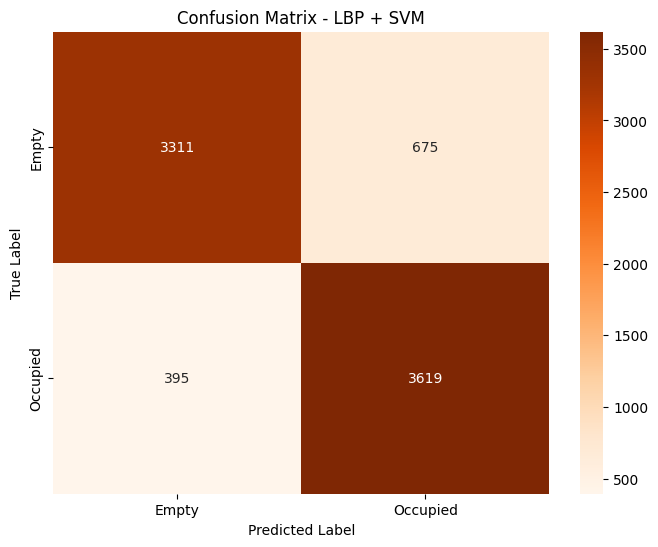

In [ ]:
# Visualize Confusion Matrix for LBP
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lbp, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Empty', 'Occupied'],
            yticklabels=['Empty', 'Occupied'])
plt.title('Confusion Matrix - LBP + SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Compare all three methods

In [ ]:
# Compare all three methods
print("=" * 80)
print("COMPARISON OF ALL FEATURE EXTRACTION METHODS")
print("=" * 80)

results_df = pd.DataFrame({
    'Method': ['HOG + SVM', 'ORB + SVM', 'LBP + SVM'],
    'CV Mean Accuracy': [cv_scores_hog.mean(), cv_scores_orb.mean(), cv_scores_lbp.mean()],
    'CV Std Dev': [cv_scores_hog.std(), cv_scores_orb.std(), cv_scores_lbp.std()],
    'Test Accuracy': [test_accuracy_hog, test_accuracy_orb, test_accuracy_lbp]
})

print("\n", results_df.to_string(index=False))
print("\n" + "=" * 80)

COMPARISON OF ALL FEATURE EXTRACTION METHODS

    Method  CV Mean Accuracy  CV Std Dev  Test Accuracy
HOG + SVM          0.974625    0.001493       0.973000
ORB + SVM          0.515469    0.001890       0.514875
LBP + SVM          0.865594    0.001464       0.866250



### Visualize comparison

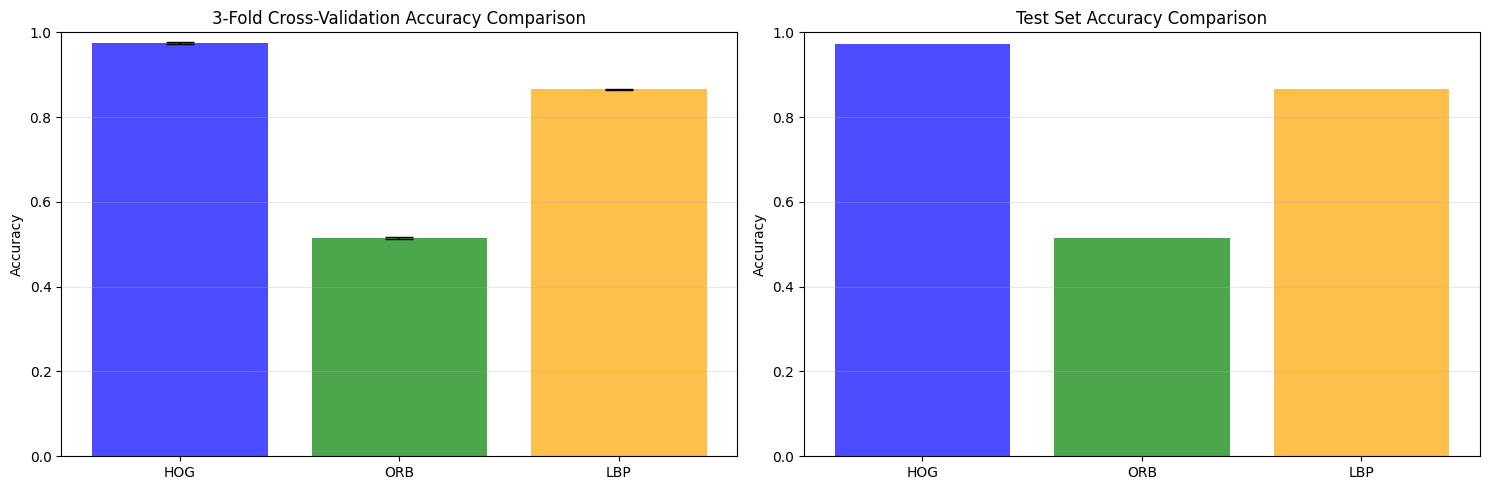

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Cross-Validation Accuracies
methods = ['HOG', 'ORB', 'LBP']
cv_means = [cv_scores_hog.mean(), cv_scores_orb.mean(), cv_scores_lbp.mean()]
cv_stds = [cv_scores_hog.std(), cv_scores_orb.std(), cv_scores_lbp.std()]

axes[0].bar(methods, cv_means, yerr=cv_stds, capsize=10, color=['blue', 'green', 'orange'], alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('3-Fold Cross-Validation Accuracy Comparison')
axes[0].set_ylim([0, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Test Accuracies
test_accs = [test_accuracy_hog, test_accuracy_orb, test_accuracy_lbp]
axes[1].bar(methods, test_accs, color=['blue', 'green', 'orange'], alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Set Accuracy Comparison')
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



  HOG + SVM achieves the best performance with 97.43% accuracy, significantly outperforming LBP (86.83%) and ORB (51.71%), making it the optimal choice for parking space occupancy classification.


## 6. CNN Data Preparation

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert labels to one-hot encoded format
y_train_cat = to_categorical(y_train, 2)
y_test_cat  = to_categorical(y_test, 2)

# Validation split for CNN training
X_train_cnn, X_val_cnn, y_train_cat, y_val_cat = train_test_split(
    X_train_cnn,
    y_train_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("\nAfter train/validation split:")
print("X_train_cnn:", X_train_cnn.shape, "y_train_cat:", y_train_cat.shape)
print("X_val_cnn:  ", X_val_cnn.shape,   "y_val_cat:",   y_val_cat.shape)
print("X_test_cnn: ", X_test_cnn.shape,  "y_test_cat:",  y_test_cat.shape)



After train/validation split:
X_train_cnn: (25600, 64, 64, 1) y_train_cat: (25600, 2)
X_val_cnn:   (6400, 64, 64, 1) y_val_cat: (6400, 2)
X_test_cnn:  (8000, 64, 64, 1) y_test_cat: (8000, 2)


##  7. Build & Train CNN Model


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

IMG_SIZE   = 64
CHANNELS   = 1
input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)

# Define CNN model
model_cnn = Sequential([
    # First convolutional layer: 32 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

    # First max pooling layer: downsample feature maps
    MaxPooling2D((2, 2)),

    # Second convolutional layer: 64 filters, 3x3 kernel
    Conv2D(64, (3, 3), activation='relu'),

    # Second max pooling layer
    MaxPooling2D((2, 2)),

    # Third convolutional layer: 128 filters for deeper features
    Conv2D(128, (3, 3), activation='relu'),

    # Third max pooling layer
    MaxPooling2D((2, 2)),

    # Flatten 2D feature maps into 1D vector
    Flatten(),

    # Fully connected dense layer with 128 neurons
    Dense(128, activation='relu'),

    # Dropout layer to reduce overfitting (50% dropout rate)
    Dropout(0.5),

    # Output layer with softmax activation (2 classes: Empty, Occupied)
    Dense(2, activation='softmax')
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the CNN model
# Adam optimizer + categorical crossentropy for multi-class classification
model_cnn.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Show model architecture
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,882 (2.60 MB)

 Trainable params: 682,882 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 15
BATCH_SIZE = 64

# Train the CNN model on parking-slot patches
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

Epoch 1/15
400/400 - 11s - 26ms/step - accuracy: 0.9195 - loss: 0.2458 - val_accuracy: 0.9619 - val_loss: 0.1303
Epoch 2/15
400/400 - 4s - 10ms/step - accuracy: 0.9635 - loss: 0.1356 - val_accuracy: 0.9656 - val_loss: 0.1128
Epoch 3/15
400/400 - 4s - 9ms/step - accuracy: 0.9678 - loss: 0.1133 - val_accuracy: 0.9672 - val_loss: 0.1132
Epoch 4/15
400/400 - 4s - 9ms/step - accuracy: 0.9701 - loss: 0.1071 - val_accuracy: 0.9692 - val_loss: 0.0993
Epoch 5/15
400/400 - 4s - 9ms/step - accuracy: 0.9709 - loss: 0.0986 - val_accuracy: 0.9675 - val_loss: 0.1009
Epoch 6/15
400/400 - 4s - 9ms/step - accuracy: 0.9711 - loss: 0.0931 - val_accuracy: 0.9708 - val_loss: 0.0910
Epoch 7/15
400/400 - 4s - 9ms/step - accuracy: 0.9720 - loss: 0.0886 - val_accuracy: 0.9706 - val_loss: 0.0963
Epoch 8/15
400/400 - 4s - 9ms/step - accuracy: 0.9736 - loss: 0.0792 - val_accuracy: 0.9711 - val_loss: 0.0936
Epoch 9/15
400/400 - 4s - 10ms/step - accuracy: 0.9740 - loss: 0.0751 - val_accuracy: 0.9702 - val_loss: 0.09

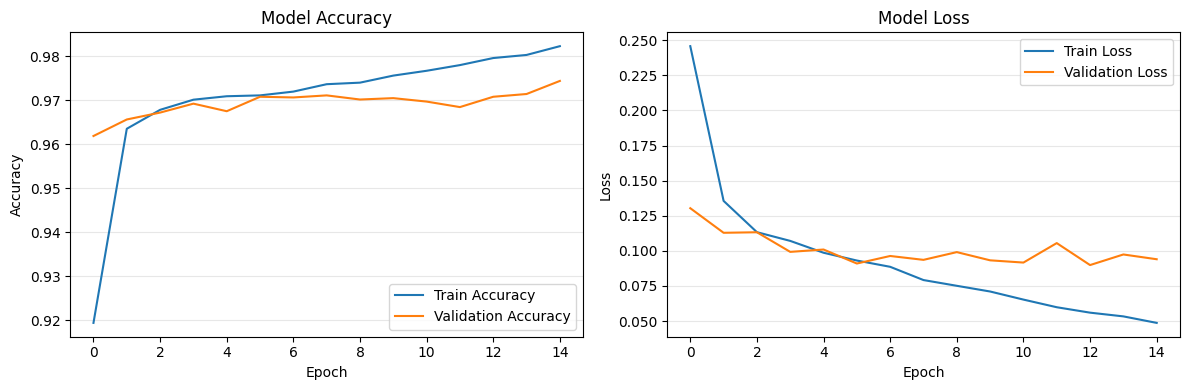

In [ ]:
# Visualize CNN Training History

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the CNN model
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)
y_pred_probs_cnn = model_cnn.predict(X_test_cnn)

# Convert predictions and true labels to single class labels (0 or 1)
y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)
y_true_cnn = np.argmax(y_test_cat, axis=1)
target_names = ['Empty', 'Occupied']

print(f"\nCNN Test Loss: {loss_cnn:.4f}")
print(f"CNN Test Accuracy: {accuracy_cnn:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

CNN Test Loss: 0.0857
CNN Test Accuracy: 0.9761



Classification Report (CNN):
              precision    recall  f1-score   support

       Empty       0.99      0.96      0.98      3986
    Occupied       0.96      0.99      0.98      4014

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000


Confusion Matrix (CNN):
 [[3823  163]
 [  28 3986]]


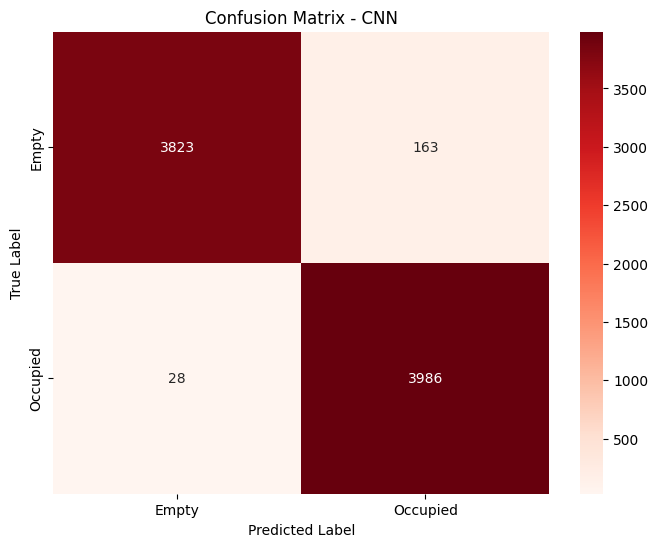

In [ ]:
# Classification Report
print("\nClassification Report (CNN):")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=target_names))

# CNN Confusion Matrix
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
print("\nConfusion Matrix (CNN):\n", cm_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Reds',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix - CNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

##  8. Evaluation & Visualization

/tmp/ipython-input-1191149966.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


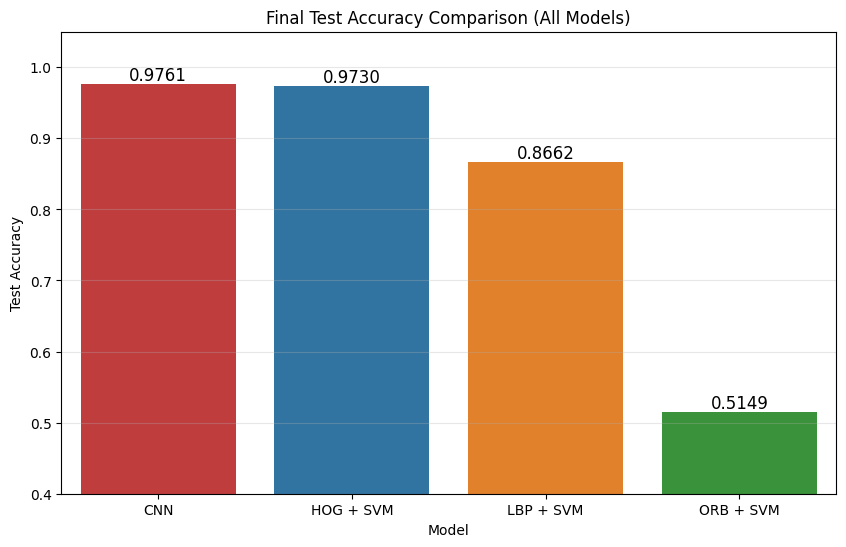

In [ ]:
hog_svm_test_accuracy = test_accuracy_hog
orb_svm_test_accuracy = test_accuracy_orb
lbp_svm_test_accuracy = test_accuracy_lbp
cnn_test_accuracy = accuracy_cnn

model_colors = [ '#d62728', '#1f77b4' , '#ff7f0e', '#2ca02c' ]

final_results_df = pd.DataFrame({
    'Model': ['HOG + SVM', 'ORB + SVM', 'LBP + SVM', 'CNN'],
    'Test Accuracy': [hog_svm_test_accuracy, orb_svm_test_accuracy, lbp_svm_test_accuracy, cnn_test_accuracy]
})

df_sorted = final_results_df.sort_values(by='Test Accuracy', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Model',
    y='Test Accuracy',
    data=df_sorted,
    palette=model_colors
)

for p in ax.patches:
    accuracy_value = p.get_height()

    ax.text(p.get_x() + p.get_width() / 2.,
            accuracy_value,
            '{:1.4f}'.format(accuracy_value),
            fontsize=12,
            color='black',
            ha='center',
            va='bottom')

plt.title('Final Test Accuracy Comparison (All Models)')
plt.ylabel('Test Accuracy')
plt.ylim(0.4, 1.05)
plt.grid(axis='y', alpha=0.3)
plt.show()

Save all models

In [ ]:
import joblib
import tensorflow as tf

#  Saving SVM Models

# 1. Save HOG + SVM Model
try:
    joblib.dump(svm_hog, 'svm_hog_model.joblib')
    print("HOG + SVM model saved as svm_hog_model.joblib")
except NameError:
    print("ERROR: svm_hog not found. Ensure the HOG + SVM model is trained.")

# 2. Save ORB + SVM Model
try:
    joblib.dump(svm_orb, 'svm_orb_model.joblib')
    print("ORB + SVM model saved as svm_orb_model.joblib")
except NameError:
    print("ERROR: svm_orb not found. Ensure the ORB + SVM model is trained.")

# 3. Save LBP + SVM Model
try:
    joblib.dump(svm_lbp, 'svm_lbp_model.joblib')
    print("LBP + SVM model saved as svm_lbp_model.joblib")
except NameError:
    print("ERROR: svm_lbp not found. Ensure the LBP + SVM model is trained.")

# Saving CNN Model

# 4. Save CNN Model
try:
    model_cnn.save('cnn_model.keras')
    print("CNN model saved as cnn_model.keras")
except NameError:
    print("ERROR: model_cnn not found. Ensure the CNN model is trained.")

HOG + SVM model saved as svm_hog_model.joblib
ORB + SVM model saved as svm_orb_model.joblib
LBP + SVM model saved as svm_lbp_model.joblib
CNN model saved as cnn_model.keras
